In [27]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import argparse
import sys

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

np.random.seed(1)
print ("cargo")

cargo


In [28]:
def datos():
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data', one_hot=True)
    print ("Dimensiones train")
    print (mnist.train.images.shape)
    print ("Dimensiones test")
    print (mnist.test.images.shape)
    print ("cargo")
    X_train_o = mnist.train.images[:55000,:]
    Y_train_o = mnist.train.labels[:55000,:]
    X_test_o = mnist.test.images[:10000,:]
    Y_test_o = mnist.test.labels[:10000,:]
    print ("Dimensiones X train")
    print (X_train_o.shape)
    print ("Dimensiones Y train")
    print (Y_train_o.shape)
    print ("Las dimensiones de X son Nx por M, donde Nx son las caracteristicas y M es el numero, por eso hay que trasponerlo")
    X_train=X_train_o.T
    Y_train=Y_train_o.T
    print ("........")
    print ("X train transpuesto", str(X_train.shape))
    print ("Y train transpuesto", str(Y_train.shape))
    X_test=X_test_o.T
    Y_test=Y_test_o.T
    print ("X test transpuesto", str(X_test.shape))
    print ("Y test transpuesto", str(Y_test.shape))
    
    return X_train, Y_train, X_test, Y_test

In [239]:
def create_placeholders(n_x, n_y):
    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32,shape=(n_x, None),name="X")
    Y = tf.placeholder(tf.float32,shape=(n_y, None),name="Y")
    ### Otras variables ###
    
     # variable learning rate
    lr = tf.placeholder(tf.float32)
    # train/test selector for batch normalisation
    tst = tf.placeholder(tf.bool)
    ##Drop Out
    pkeep = tf.placeholder(tf.float32)
    # training iteration
    #iter = tf.placeholder(tf.int32)   
    
    return X, Y, tst,pkeep

In [240]:
def initialize_parameters(n_x,n_y):
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 =  tf.get_variable("W1", [25,n_x], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 =  tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 =  tf.get_variable("W3", [n_y,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [n_y,1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [241]:
def batchnorm(Ylogits, is_test):
    Ylogits = tf.transpose(Ylogits)
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    ##con 0 el calculo es vertical
    mean, variance = tf.nn.moments(Ylogits, [0])
    
    update_moving_averages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, None, None, bnepsilon)
    Ybn = tf.transpose(Ybn)
    return Ybn, update_moving_averages

In [242]:
def forward_propagation(X, parameters,tst,pkeep):   
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    #Z1 = tf.add(tf.matmul(W1,X),b1)  
    Z1 = tf.matmul(W1,X)                                              # Z1 = np.dot(W1, X) + b1
    Z1B, update_ema1 = batchnorm(Z1, tst)
    
    A1 = tf.nn.relu(Z1B)                                              # A1 = relu(Z1)
    A1d = tf.nn.dropout(A1, pkeep)
    
    #Z2 = tf.add(tf.matmul(W2,A1),b2)
    
    Z2 = tf.matmul(W2,A1d)                                               # Z2 = np.dot(W2, a1) + b2
    Z2B, update_ema2 = batchnorm(Z2, tst)
    
    A2 = tf.nn.relu(Z2B)                                              # A2 = relu(Z2)
    A2d = tf.nn.dropout(A2, pkeep)
    
    Z3 = tf.add(tf.matmul(W3,A2d),b3)                                             # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    #update_ema = tf.group(update_ema1)
    return Z3

In [243]:
# GRADED FUNCTION: compute_cost 
def compute_cost(Z3, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ### END CODE HERE ###
    
    return cost

In [244]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [248]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 30, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    #print (n_x)
    #print (m)
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y,tst, pkeep= create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    ### inicializar los parametros y la arquitectura de la red
    parameters = initialize_parameters(n_x,n_y)
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters,tst,pkeep)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3,Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    ##### Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        i=0
        for epoch in range(num_epochs):
            i=i+1
            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            #print ("mini "+str(num_minibatches))
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, tst: False,pkeep:0.75})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches
                #if(i==30):
                #    break

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                print ("epoch",str(epoch))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
  

        # plot the cost
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions, xq no recibe a3. Claro no lo tengo. ¿como sabe que debe calcularlo?
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train,tst: False,pkeep:0.75}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test,tst: True,pkeep:1}))
        '''
        print ("Train Accuracy:", sess.run(accuracy, feed_dict ={X: X_train, Y: Y_train})

        print ("Test Accuracy:", sess.run(accuracy, feed_dict ={X: X_test, Y: Y_test})
        
        '''
        print ("Termino")
        return parameters

In [249]:
X_train, Y_train, X_test, Y_test = datos()

Extracting /tmp/tensorflow/mnist/input_data\train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data\t10k-labels-idx1-ubyte.gz
Dimensiones train
(55000, 784)
Dimensiones test
(10000, 784)
cargo
Dimensiones X train
(55000, 784)
Dimensiones Y train
(55000, 10)
Las dimensiones de X son Nx por M, donde Nx son las caracteristicas y M es el numero, por eso hay que trasponerlo
........
X train transpuesto (784, 55000)
Y train transpuesto (10, 55000)
X test transpuesto (784, 10000)
Y test transpuesto (10, 10000)


Cost after epoch 0: 1.832114
epoch 0


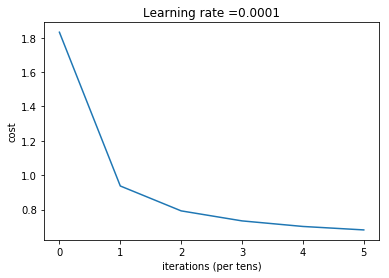

Parameters have been trained!
Train Accuracy: 0.807873
Test Accuracy: 0.8959
Termino
Wall time: 2min


In [250]:
%%time
parameters = model(X_train, Y_train, X_test, Y_test)